In [ ]:
#Visual notebook for get data workflow 4

In [1]:
#Imports
import matplotlib.pyplot as plt
import pandas as pd
from collections import Counter
import os
import random
import glob
import numpy as np
import seaborn as sns
import pdb

In [2]:
#Initial grouping of files
#Functions
def read_tsv(H_groups_file):
	'''Read ids and H-groups into dict
	'''

	H_groups = {} #Store H-groups and uids

	with open(H_groups_file) as file:
		for line in file:
			line = line.rstrip() #remove \n
			line = line.split(',')
			uid = line[0]
			H_group = line[1:]
			H_group = H_group[0]+'.'+H_group[1]+'.'+H_group[2]+'.'+H_group[3]
			H_groups[uid] = H_group


	return H_groups

def read_fasta(fasta_file):
	'''Read fasta file into dict
	'''

	sequences = {} #Store sequences

	with open(fasta_file) as file:
		for line in file:
			line = line.rstrip() #remove \n
			if line[0] == '>':
				uid = line.split('|')[2].split('/')[0]
			else:
				sequences[uid] = line

	return sequences


def get_groups(H_groups, sequences):
	'''Get H-group for each uid and group sequences accordingly
	'''


	grouped_sequences = {} #Sequences grouped by H-group

	for key in sequences:
		H_group = H_groups[key]
		sequence = sequences[key]

		if H_group not in grouped_sequences.keys(): #If not in new dict - add
			grouped_sequences[H_group] = [key + '/' + sequence]
		else:
			grouped_sequences[H_group].append(key + '/' + sequence) #Otherwise append

	return grouped_sequences



H_groups = read_tsv('/home/pbryant/data/CATH/h_grouped/H_group.tsv')
sequences = read_fasta('/home/pbryant/data/CATH/reallybelow95.fa')
grouped_sequences = get_groups(H_groups, sequences)

In [3]:
print('Original number of groups:',len(Counter(H_groups.values()).keys()))
print('Groups with no more than 95 % sequence identity:',len(grouped_sequences.keys()))
print(len(sequences))

Original number of groups: 6119
Groups with no more than 95 % sequence identity: 6002
54271


In [4]:
failed_pdb_filter = pd.read_csv('/home/pbryant/data/CATH/failed_pdb_filter_2.6Å.txt', sep = '\n', header = None)
u_hgroups = []
for row in failed_pdb_filter[0]:
    group = H_groups[row]
    if group in u_hgroups:
        continue
    else:
        u_hgroups.append(group)
print('Failed groups:',len(u_hgroups), '|Failed uids:',len(failed_pdb_filter))
#Should count how many groups disappear by removing the uids that failed

Failed groups: 2984 |Failed uids: 12723


In [5]:
failed_uids = [*failed_pdb_filter[0]]
passed_uids = []
for uid in sequences:
    if uid in failed_uids:
        continue
    else:
        passed_uids.append(uid)
    
    

In [18]:
print(len(passed_uids))
print(len(failed_uids))
print(len(passed_uids)+len(failed_uids))
print(len(sequences))

41548
12723
54271
54271


In [6]:
H_groups = read_tsv('/home/pbryant/data/CATH/h_grouped/H_group.tsv')
passed_uids_grouped = {} #Sequences grouped by H-group
for uid in passed_uids:
    H_group = H_groups[uid]
       
    if H_group not in passed_uids_grouped.keys(): #If not in new dict - add
        passed_uids_grouped[H_group] = [uid]
    else:
        passed_uids_grouped[H_group].append(uid) #Otherwise append


Text(0.5, 1.0, 'At least 2 entries\nTotal number of entries: 39211\nTotal number of groups: 2489')

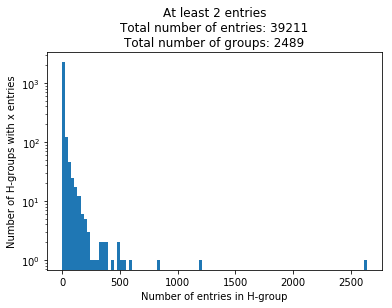

In [7]:
num_entries = []
over_x = []
x = 2
passed_uids_grouped_over_x = {}
for key in passed_uids_grouped:
    num_uids = len(passed_uids_grouped[key])
    num_entries.append(num_uids)
    if num_uids >= x:
        over_x.append(num_uids)
        passed_uids_grouped_over_x[key]=passed_uids_grouped[key]
plt.hist(over_x, bins = 100, log = True)
plt.xlabel('Number of entries in H-group')
plt.ylabel('Number of H-groups with x entries')
average = sum(over_x)/len(over_x)
plt.title('At least 2 entries\n'+'Total number of entries: '+str(sum(over_x)) + '\n' +'Total number of groups: ' + str(len(over_x)))

In [48]:
#passed_uids_grouped_over_x
outdir = '/home/pbryant/data/CATH/h_grouped/below95_2.6Å_above2_grouped/'
for group in passed_uids_grouped_over_x:
    group_dir = outdir+group
    os.mkdir(group_dir)
    uids = passed_uids_grouped_over_x[group]
    for uid in uids:
        sequence = sequences[uid]
        with open(group_dir+'/'+uid+'.fa', "w") as file:
            file.write('>'+uid+'\n')
            i = 0 #index
            while i<len(sequence):
                file.write(sequence[i:i+60]+'\n')
                i+=60
        


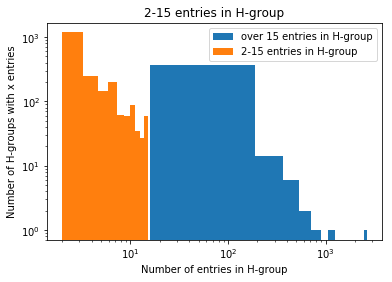

Number of entries in groups with over 2, but under 15 entries: 9322
Number of entries in groups with over 15 entries: 29889
Number of groups with under 15 entries: 2102
Number of groups with above 15 entries: 387
Number of possible uids considering groups with above 2, but no more than 15 entries: 15127
Number of possible uid pairs considering groups with above 2, but no more than 15 entries: 67445


In [13]:
over_y = []
under_y = []
number_possible_uids = 0
number_possible_pairs = 0
y = 15
for i in over_x:
    if i>y:
        over_y.append(i)
        number_possible_uids+=15
        number_possible_pairs+=105
    else:
        under_y.append(i)
        number_possible_uids+=i
        number_possible_pairs+=(i*(i-1)/2)
plt.hist(over_y, bins = 15, label = 'over 15 entries in H-group')
plt.hist(under_y, bins = 10, label = '2-15 entries in H-group')
plt.legend()
plt.yscale('log')
plt.xscale('log')
plt.xlabel('Number of entries in H-group')
plt.ylabel('Number of H-groups with x entries')
plt.title('2-15 entries in H-group')
plt.show()
print('Number of entries in groups with over 2, but under 15 entries:',sum(under_y))
print('Number of entries in groups with over 15 entries:',sum(over_y))
print('Number of groups with under 15 entries:',len(under_y))
print('Number of groups with above 15 entries:',len(over_y))
print('Number of possible uids considering groups with above 2, but no more than 15 entries:',number_possible_uids)
print('Number of possible uid pairs considering groups with above 2, but no more than 15 entries:',int(number_possible_pairs))

In [2]:
#From tmscore aln
# use your path
all_files = glob.glob('/home/p/pbryant/pfs/results/CATH/20190826/*/*seq.tsv')     # advisable to use os.path.join as this makes concatenation OS independent

df_from_each_file = [pd.read_csv(f, sep='\t') for f in all_files]
c = 0
for dataframe, filename in zip(df_from_each_file, all_files):
    hgroup = filename.split('/')[-2]
    dataframe['H_group'] = filename.split('/')[-2]
    dataframe['C.'] = hgroup.split('.')[0]+'.'
    dataframe['C.A.'] = hgroup.split('.')[0]+'.'+hgroup.split('.')[1]
    c+=1
print(c)
from_seq_df = pd.concat(df_from_each_file, ignore_index=True)

2489


In [3]:
from_seq_df.to_csv('/home/p/pbryant/pfs/results/CATH/20190826/from_seq_df.csv')
len(from_seq_df)

66956

In [5]:
#From tmalign alignments
all_files = glob.glob('/home/p/pbryant/pfs/results/CATH/20190826/*/TMalign/*str.tsv')     # advisable to use os.path.join as this makes concatenation OS independent

df_from_each_file = [pd.read_csv(f, sep='\t') for f in all_files]
for dataframe, filename in zip(df_from_each_file, all_files):
    hgroup = filename.split('/')[-3]
    dataframe['H_group'] = hgroup
    dataframe['C.'] = hgroup.split('.')[0]+'.'
    dataframe['C.A.'] = hgroup.split('.')[0]+'.'+hgroup.split('.')[1]
from_str_df = pd.concat(df_from_each_file, ignore_index=True)
from_str_df.to_csv('/home/p/pbryant/pfs/results/CATH/20190826/from_str_df.csv')
len(from_str_df)

67445

In [9]:
#Save all alignements and their metrics for the hhalign sequence alignments
all_files = glob.glob('/home/p/pbryant/pfs/results/CATH/20190826/*/*.aln')     # advisable to use os.path.join as this makes concatenation OS independent

uid1 = []
uid2 = []
l1 = []
s1 = []
e1 = []
l2 = []
s2 = []
e2 = []
aln_len = []
identities = []
e_values = []
probabilities = []
seq1 = []
seq2 = []
for name in all_files:
    with open(name, 'r') as file:
        for line in file:
            line = line.rstrip() #remove \n
            if '>' in line:
                uid = line[1:8]
                line = line.split('|') #Split
                if len(uid1)>len(uid2): #append to uid lists
                    uid2.append(uid)
                    l2.append(int(line[1].split('=')[1]))
                    s2.append(int(line[2].split('=')[1]))
                    e2.append(int(line[3].split('=')[1]))
                else:
                    uid1.append(uid)
                    l1.append(int(line[1].split('=')[1]))
                    s1.append(int(line[2].split('=')[1]))
                    e1.append(int(line[3].split('=')[1]))
                    aln_len.append(int(line[4].split('=')[1]))
                    identities.append(float(line[5].split('=')[1]))
                    e_values.append(float(line[6].split('=')[1]))
                    probabilities.append(float(line[7].split('=')[1]))                 
            else:
                sequence = line
                if len(seq1)>len(seq2):
                    seq2.append(sequence)
                else:
                    seq1.append(sequence)
                

seq_aln_df = pd.DataFrame(list(zip(uid1, uid2, aln_len, identities, e_values, probabilities, seq1, seq2, l1, l2, s1, s2, e1, e2)), columns = ['uid1','uid2','aln_len','identity', 'e_value', 'probability', 'seq1', 'seq2', 'l1', 'l2', 's1', 's2', 'e1', 'e2'])
print(len(seq_aln_df))
seq_aln_df.to_csv('/home/p/pbryant/pfs/results/CATH/20190826/seq_aln_df.csv')

67445


In [10]:
complete_seq_df = pd.merge(from_seq_df, seq_aln_df,  on=['uid1', 'uid2'], how='left')
print(len(complete_seq_df))
complete_seq_df.to_csv('/home/p/pbryant/pfs/results/CATH/20190826/complete_seq_df.csv')

66956


In [12]:
#Get lddt scores for complete seq_df

base = '/home/p/pbryant/pfs/results/CATH/20190826/'
lddt_scores = []
failed_c = 0
for i in range(0,len(complete_seq_df)):
    row = complete_seq_df.iloc[i]
    
    file_name = base+row['H_group']+'/'+row['uid1']+'_'+row['uid2']+'.lddt'

    try:
        with open(file_name, 'r') as file:
            for row in file:
                if 'Global LDDT score:' in row:
                    row = row.split()
                    score = float(row[-1])
                    lddt_scores.append(score)
                    break
    except:
        failed_c +=1

complete_seq_df['global_lddt'] = lddt_scores
complete_seq_df.to_csv('/home/p/pbryant/pfs/results/CATH/20190826/complete_seq_df.csv')           
failed_c

FileNotFoundError: [Errno 2] No such file or directory: '/home/p/pbryant/pfs/results/CATH/20190826/3.40.120.10/3uw2A03_1p5dX02.lddt'

In [14]:
#Calculate percent aligned
percent_aligned = []
for index, row in complete_seq_df.iterrows():
    min_len = min(row['l1'], row['l2'])
    percent_aligned.append(row['aln_len']/min_len)
complete_seq_df['percent_aligned'] = percent_aligned
complete_seq_df.to_csv('/home/p/pbryant/pfs/results/CATH/20190826/complete_seq_df.csv') 

In [15]:
complete_seq_df = pd.read_csv('/home/p/pbryant/pfs/results/CATH/20190826/complete_seq_df.csv')
complete_seq_df.columns

Index(['Unnamed: 0', 'Unnamed: 0.1', 'uid1', 'uid2', 'MLAAdist', 'RMSD',
       'TMscore', 'GDT-TS', 'GDT-HA', 'H_group', 'C.', 'C.A.', 'aln_len',
       'identity', 'e_value', 'probability', 'seq1', 'seq2', 'l1', 'l2', 's1',
       's2', 'e1', 'e2', 'percent_aligned'],
      dtype='object')

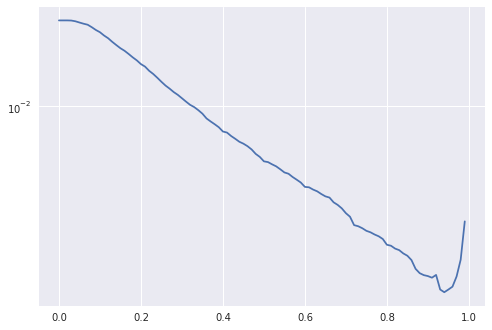

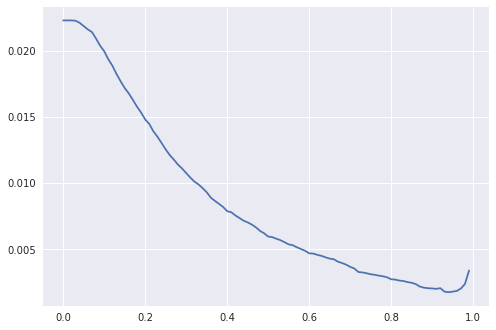

In [28]:
plt.plot(thresholds, av_eval)
plt.yscale('log')
plt.show()
plt.plot(thresholds, av_eval)
plt.show()

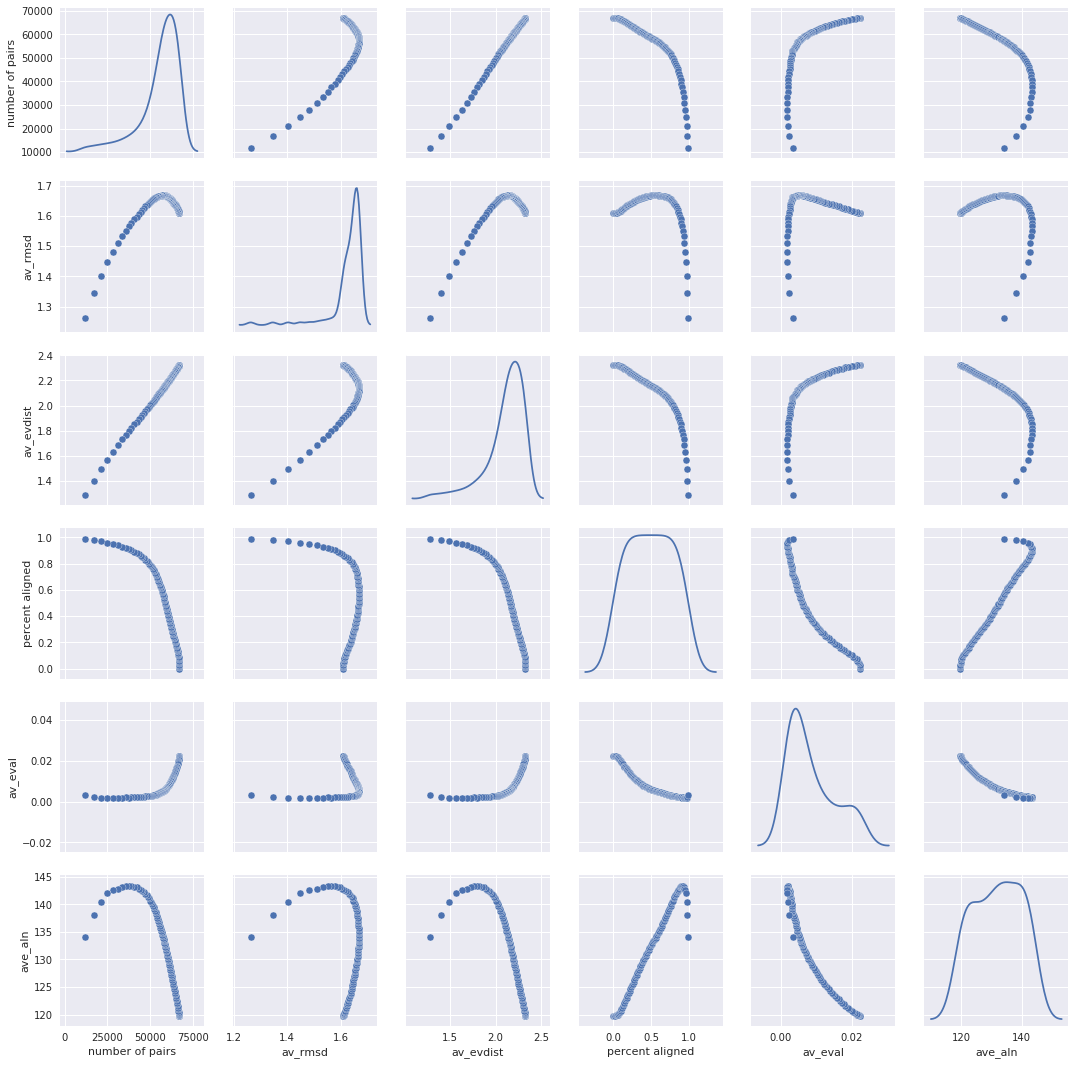

In [16]:
#Look how many entries have above x percent aligned with a step size of 1
above_x_aligned = []
av_rmsd = []
av_evdist = []
av_eval = []
ave_aln = []

thresholds = np.arange(0.,1.0,0.01)
for t in thresholds:
    over_df = complete_seq_df[complete_seq_df['percent_aligned']>t]
    num_over = len(over_df)
    above_x_aligned.append(num_over)
    av_rmsd.append(over_df['RMSD'].sum()/num_over)
    av_evdist.append(over_df['MLAAdist'].sum()/num_over)
    av_eval.append(over_df['e_value'].sum()/num_over)
    ave_aln.append(over_df['aln_len'].sum()/num_over)
    


t_df = pd.DataFrame(list(zip(above_x_aligned, av_rmsd, av_evdist, thresholds, av_eval,ave_aln)), 
                      columns = ['number of pairs', 'av_rmsd', 'av_evdist', 'percent aligned', 'av_eval','ave_aln'])
sns.pairplot(t_df, vars = ['number of pairs', 'av_rmsd', 'av_evdist', 'percent aligned', 'av_eval','ave_aln'],diag_kind = 'kde')
plt.show()

In [78]:
complete_seq_df.isnull().any()

Unnamed: 0         False
Unnamed: 0.1       False
uid1               False
uid2               False
MLAAdist           False
RMSD                True
TMscore            False
GDT-TS             False
GDT-HA             False
H_group            False
C.                 False
C.A.               False
aln_len            False
identity           False
e_value            False
probability        False
seq1               False
seq2               False
l1                 False
l2                 False
s1                 False
s2                 False
e1                 False
e2                 False
percent_aligned    False
dtype: bool

In [83]:
#Some RMSDs are NaN - I drop these
complete_seq_df[complete_seq_df['RMSD'].isnull()]

,Unnamed: 0,Unnamed: 0.1,uid1,uid2,MLAAdist,RMSD,TMscore,GDT-TS,GDT-HA,H_group,...,probability,seq1,seq2,l1,l2,s1,s2,e1,e2,percent_aligned
755,755,755,3djdB02,1pn0A02,8.99886,NaN,0.0091,0.2500,0.0,3.30.9.10,...,0.05,NWRDTLGRFGGPNR,PDENGHIRRTDRIP,206,21,172,8,185,21,0.666667
2937,2937,2937,4ywaA00,1hn0A01,0.99359,NaN,0.0049,0.2500,0.0,2.60.120.430,...,0.67,FRWVAPNN-VQGAITL,IRFKAPSNVSQGEIYI,121,186,82,171,96,186,0.123967
2958,2958,2958,1v0aA01,2o14A01,2.72579,NaN,0.0085,0.2500,0.0,2.60.120.430,...,0.36,LKISFDIKSVDGSANEIRFXI,SNNTFNVDLPNG---LYEVKV,171,93,69,76,89,93,0.193548
2968,2968,2968,2o14A01,1wmxA00,2.16372,NaN,0.0077,0.2500,0.0,2.60.120.430,...,0.37,GQLNLLVTEGKAGTAFTL,GYLEFDIKGKEGGEDFVI,161,102,130,85,147,102,0.176471
3877,3877,3877,3b5nD00,4jf7B01,8.99844,NaN,0.0039,0.2500,0.0,1.20.5.110,...,0.33,QQVSNRLKKMALTT,STLLTAIKSLQTSD,64,53,16,40,29,53,0.264151
9127,9127,9127,4j2gA00,4extC00,3.07397,NaN,0.0021,0.0000,0.0,3.30.900.10,...,46.69,XLERWLIQXDNGEDSPSLQSSGSEDTDDNVSELYRQLVLLFRYLET...,PVEKFVFEITQPPL-------LSISSDSLLSHVEQLLRAFILKISV...,257,133,112,89,163,133,0.338346
9130,9130,9130,4j2gA00,4tzmB00,2.59293,NaN,0.0026,0.0000,0.0,3.30.900.10,...,28.22,XLERWLIQXDNGEDSPSLQSSGSED---------------------...,AIEVFSMKFIYFENGG--------VVARLSTDNNDQEDPHFAELAQ...,257,188,112,121,164,188,0.239362
9351,9351,9351,2nvnA00,4kopD00,4.81522,NaN,0.0098,0.2500,0.0,2.30.31.10,...,1.65,GTTDWAVELTAAEXADFCRLVQ,TNDYFVVPVTKAEFAVMKTAFS,122,154,28,133,49,154,0.180328
12379,12379,12379,5groA00,2hqlA01,3.15768,NaN,0.0043,0.2500,0.0,2.40.50.140,...,12.29,VRSEFVLVAKGKVR,TKKYKTISIEGILR,115,77,73,64,86,77,0.181818
12433,12433,12433,1se8A01,1gvpA00,2.00512,NaN,0.0030,0.0000,0.0,2.40.50.140,...,0.50,NLKGGDAVVVEGT,TLDEGQPAYAPGL,116,60,70,48,82,60,0.216667


In [85]:
complete_seq_df = complete_seq_df.dropna()
complete_seq_df.to_csv('/home/p/pbryant/pfs/results/CATH/20190821/complete_seq_df.csv')

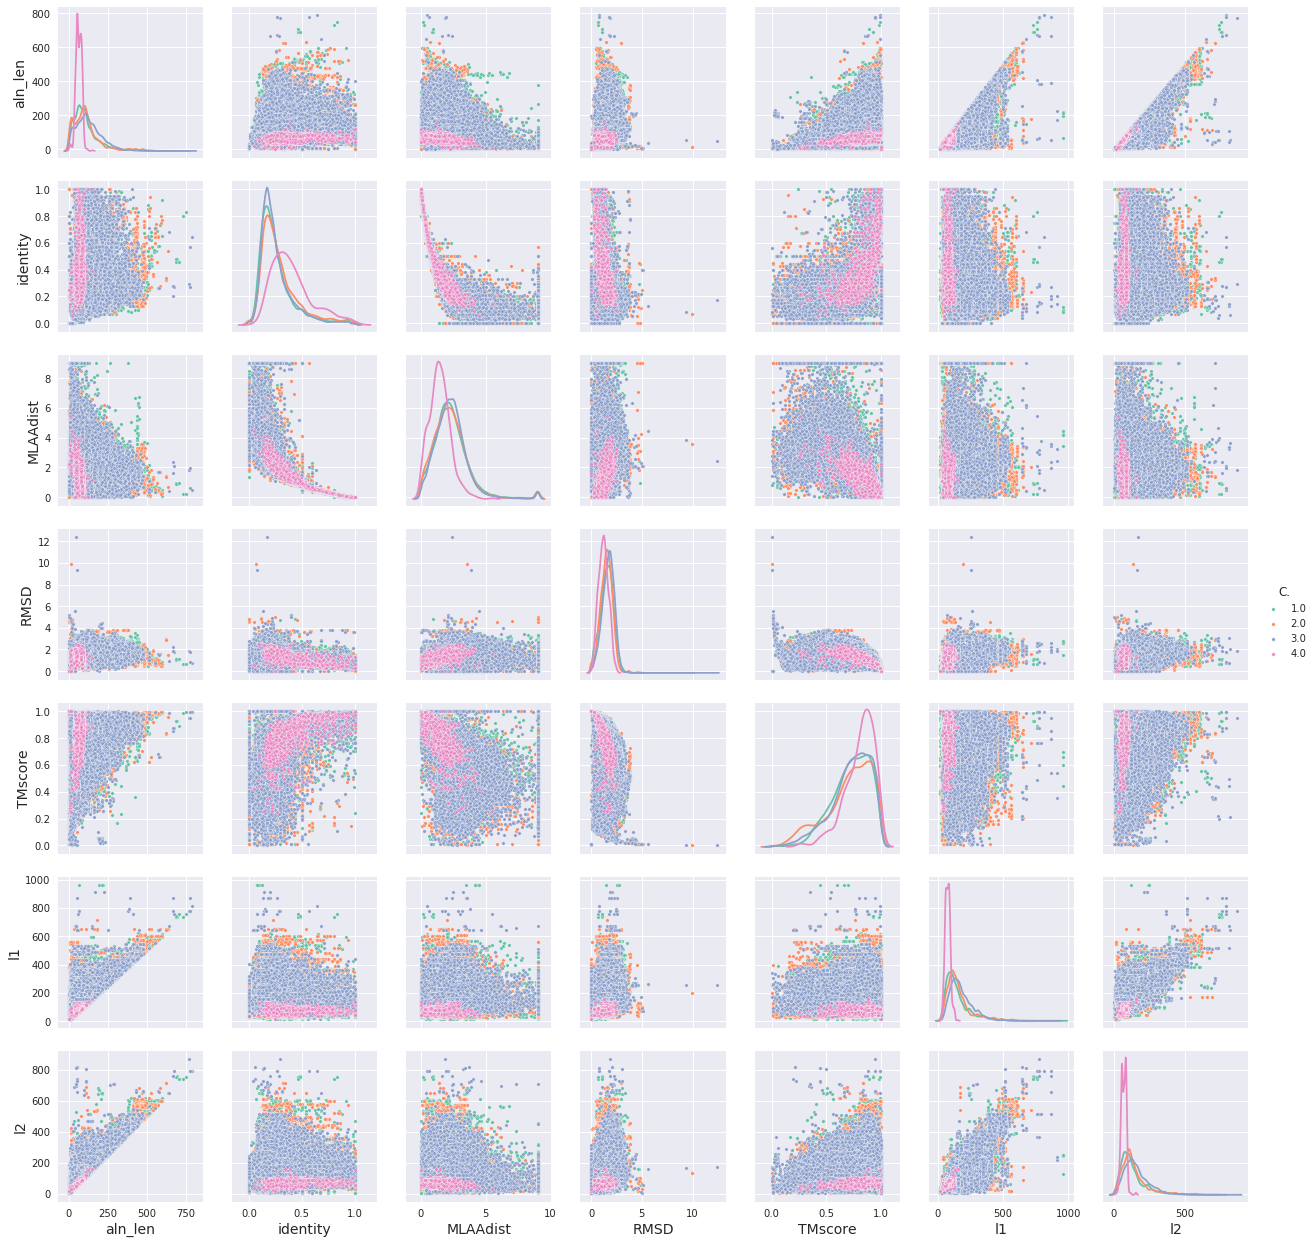

In [105]:
#Investigate those with more than 75 % aligned of the shortest sequence
sns.pairplot(data = complete_seq_df, hue ='C.', vars = ['aln_len', 'identity', 'MLAAdist', 'RMSD','TMscore','l1','l2'],diag_kind = 'kde', palette="Set2", markers=".")
plt.show()

In [9]:
CAs = []
for index, row in complete_seq_df.iterrows():
    group = row['H_group']
    group = group.split('.')
    CAs.append(group[0]+'.'+group[1])
complete_seq_df['C.A.'] = CAs
complete_seq_df.to_csv('/home/p/pbryant/pfs/results/CATH/20190821/complete_seq_df.csv')
complete_seq_df.head

<bound method NDFrame.head of        Unnamed: 0  Unnamed: 0.1  Unnamed: 0.1.1     uid1     uid2  MLAAdist  \
0               0             0               0  2dgjA01  2dgjB02   0.86029   
1               1             1               1  2iu4A02  1oi2A02   1.33061   
2               2             2               2  2iu4A02  3ct4A02   0.86795   
3               3             3               3  1oi2A02  3ct4A02   1.37535   
4               4             4               4  3kh5A02  4nocD00   2.63457   
5               5             5               5  4o9kA00  4gqwA00   2.52463   
6               6             6               6  3fnaA00  2yvyA02   2.12661   
7               7             7               7  3fnaA00  3k2vA00   0.15214   
8               8             8               8  2nycA00  3fnaA00   2.23725   
9               9             9               9  4cooA03  4nocD00   2.33057   
10             10            10              10  2qrdE01  3fnaA00   2.47433   
11             11     

In [10]:
CAs

['1.20',
 '3.30',
 '3.30',
 '3.30',
 '3.10',
 '3.10',
 '3.10',
 '3.10',
 '3.10',
 '3.10',
 '3.10',
 '3.10',
 '3.10',
 '3.10',
 '3.10',
 '3.10',
 '3.10',
 '3.10',
 '3.10',
 '3.10',
 '3.10',
 '3.10',
 '3.10',
 '3.10',
 '3.10',
 '3.10',
 '3.10',
 '3.10',
 '3.10',
 '3.10',
 '3.10',
 '3.10',
 '3.10',
 '3.10',
 '3.10',
 '3.10',
 '3.10',
 '3.10',
 '3.10',
 '3.10',
 '3.10',
 '3.10',
 '3.10',
 '3.10',
 '3.10',
 '3.10',
 '3.10',
 '3.10',
 '3.10',
 '3.10',
 '3.10',
 '3.10',
 '3.10',
 '3.10',
 '3.10',
 '3.10',
 '3.10',
 '3.10',
 '3.10',
 '3.10',
 '3.10',
 '3.10',
 '3.10',
 '3.10',
 '3.10',
 '3.10',
 '3.10',
 '3.10',
 '3.10',
 '3.10',
 '3.10',
 '3.10',
 '3.10',
 '3.10',
 '3.10',
 '3.10',
 '3.10',
 '3.10',
 '3.10',
 '3.10',
 '3.10',
 '3.10',
 '3.10',
 '3.10',
 '3.10',
 '3.10',
 '3.10',
 '3.10',
 '3.10',
 '3.10',
 '3.10',
 '3.10',
 '3.10',
 '3.10',
 '3.10',
 '3.10',
 '3.10',
 '3.10',
 '3.10',
 '3.10',
 '3.10',
 '3.10',
 '3.10',
 '3.10',
 '3.10',
 '3.10',
 '3.10',
 '3.10',
 '3.10',
 '1.20',
 '1.20',
 

{1: 'Alpha', 2: 'Beta', 3: 'Alpha Beta', 4: 'Few 2ndary str'}


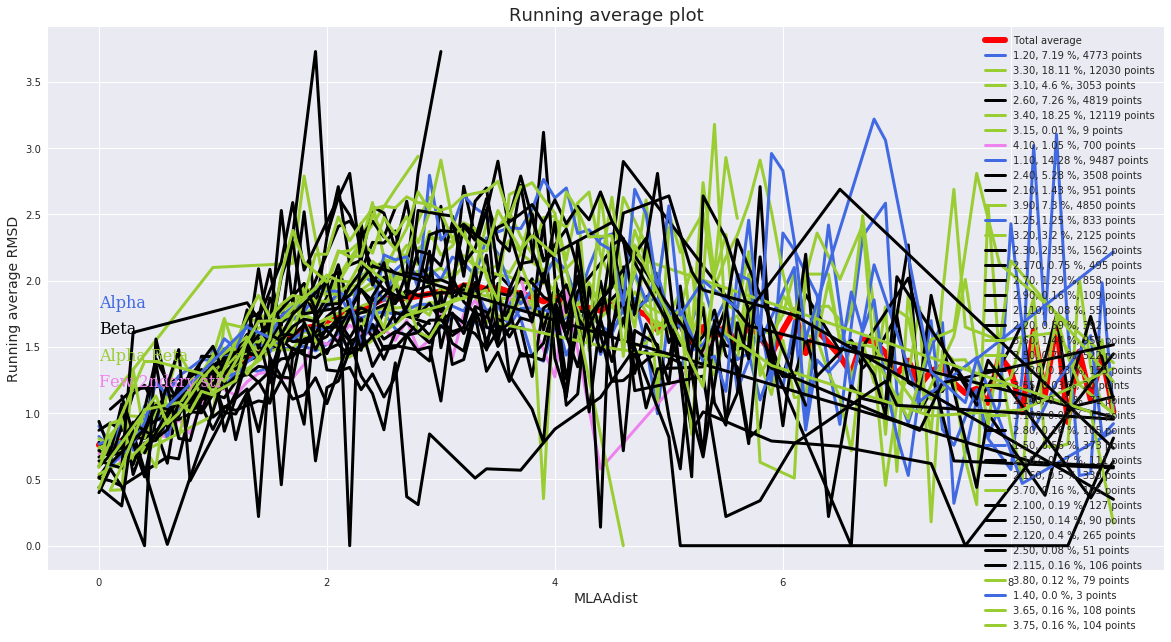

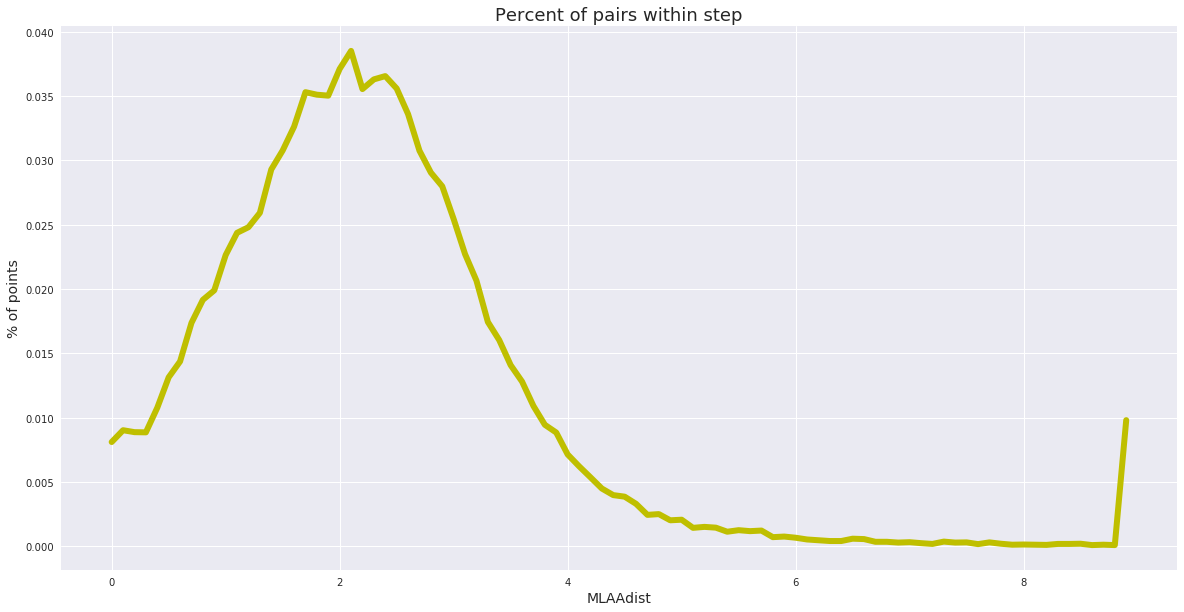

In [21]:
complete_df = complete_seq_df#[complete_seq_df['percent_aligned']>0.75]
classes = {1:'Alpha', 2: 'Beta', 3: 'Alpha Beta', 4: 'Few 2ndary str'}
print(classes)
colors = {1: 'royalblue', 2: 'k', 3: 'yellowgreen', 4: 'violet'}
ucas = [*Counter([*complete_df['C.A.']]).keys()]
#ucas = [1.,2.,3.,4.]
fig = plt.figure(figsize=(20,10))
sizes = {}

#Plot total average
avs = [] #Save average score
tjs = [] #Save dists
perc_points = []
total_avs = {}
step = 0.1
df = complete_df
mldists = np.asarray(df['MLAAdist'])
scores = np.asarray(df['RMSD'])
for j in np.arange(min(mldists)+step,max(mldists)+step,step):
    below_df = df[df['MLAAdist']<j]
    below_df = below_df[below_df['MLAAdist']>j-step]
    cut_scores = np.asarray(below_df['RMSD'])
    av= np.average(cut_scores)
    avs.append(av)
    tjs.append(j-step)
    total_avs[j-step] = av
    perc_points.append(len(below_df)/len(complete_df))

plt.plot(tjs, avs, label = 'Total average', color = 'r', linewidth = 6)

    
#Save distance from average
distance_from_av = {}

for uca in ucas:
    df = complete_df[complete_df['C.A.']==uca]
    mldists = np.asarray(df['MLAAdist'])
    scores = np.asarray(df['RMSD'])
    #plt.scatter(mldists, scores, color = 'wheat')
    avs = [] #Save average score
    js = [] #Save dists
    distance_from_av[uca] = []

    for j in np.arange(step,max(mldists)+step,step):
        below_df = df[df['MLAAdist']<j]
        below_df = below_df[below_df['MLAAdist']>j-step]
        cut_scores = np.asarray(below_df['RMSD'])
        if cut_scores.size == 0:
            continue
        av= np.average(cut_scores)
        avs.append(av)
        js.append(j-step)
                    
        
        distance_from_av[uca].append(av-total_avs[j-step])

    perc = np.round(len(df)*100/len(complete_df),2)
    sizes[uca] = perc
    plt.plot(js, avs, label = uca+', '+str(perc)+' %, '+str(len(df))+' points', color =colors[int(df['C.'].values[0])], linewidth = 3)
   

#Plot Class
y = 1.8
font = {'family': 'serif', 'color':  colors[1], 'weight': 'normal', 'size': 16}
plt.text(0, y, classes[1], fontdict=font)
font = {'family': 'serif', 'color':  colors[2], 'weight': 'normal', 'size': 16}
plt.text(0, y-0.2, classes[2], fontdict=font)
font = {'family': 'serif', 'color':  colors[3], 'weight': 'normal', 'size': 16}
plt.text(0, y-0.4, classes[3], fontdict=font)
font = {'family': 'serif', 'color':  colors[4], 'weight': 'normal', 'size': 16}
plt.text(0, y-0.6, classes[4], fontdict=font)
plt.legend(loc = 'best')
#plt.xscale('log')
plt.xlabel('MLAAdist')
plt.ylabel('Running average RMSD')
plt.title('Running average plot')
plt.rc('axes', titlesize=18, labelsize=14)
plt.show()

fig = plt.figure(figsize=(20,10))
plt.plot(tjs, perc_points, label = 'Percent of total number of points', color = 'y', linewidth = 6)
plt.xlabel('MLAAdist')
plt.ylabel('% of points')
plt.title('Percent of pairs within step')
plt.show()

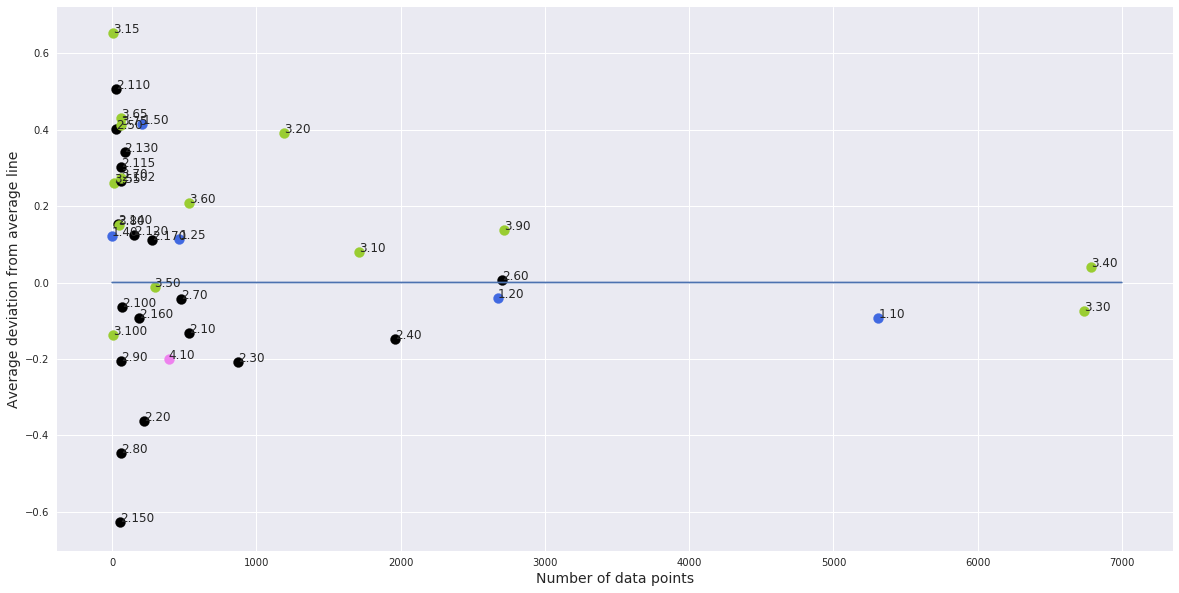

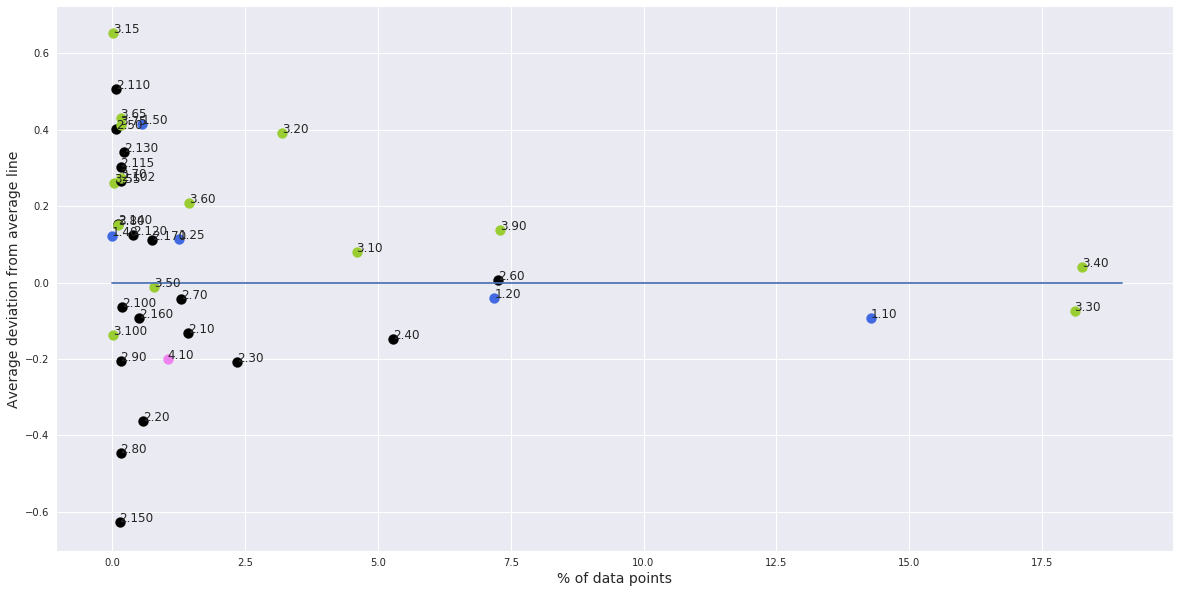

In [22]:
#Plot average distance from average line
fig = plt.figure(figsize=(20,10))
for key in sizes:
    plt.scatter(sizes[key]/100*37195, np.average(distance_from_av[key]), label = key, color = colors[int(key[0])],s=100)
    plt.annotate(key, (sizes[key]/100*37195, np.average(distance_from_av[key])))
plt.plot(range(0,7000), [0]*7000)
plt.xlabel('Number of data points')
plt.ylabel('Average deviation from average line')
plt.show()

fig = plt.figure(figsize=(20,10))
for key in sizes:
    plt.scatter(sizes[key], np.average(distance_from_av[key]), label = key, color = colors[int(key[0])],s=100)
    plt.annotate(key, (sizes[key], np.average(distance_from_av[key])))
plt.plot(range(0,20), [0]*20)
plt.xlabel('% of data points')
plt.ylabel('Average deviation from average line')
plt.show()

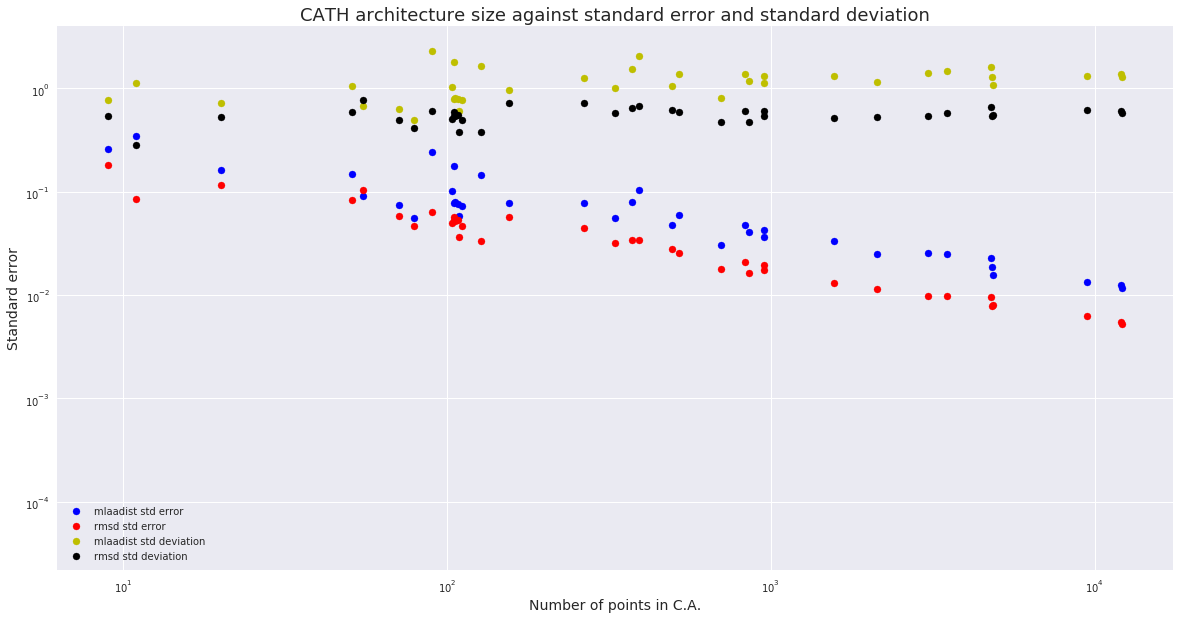

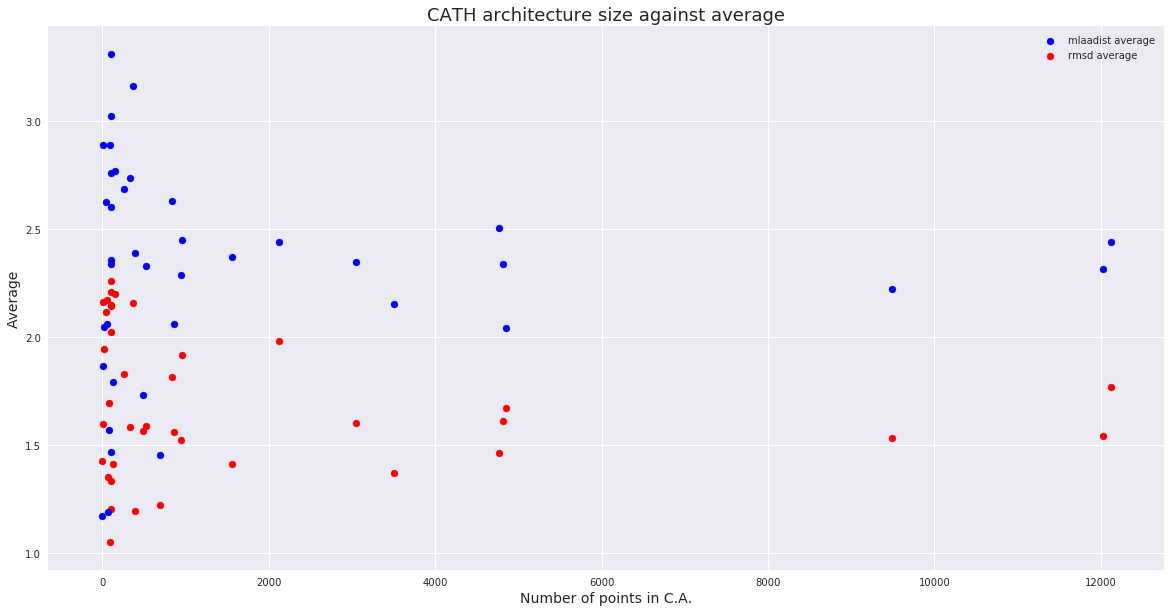

In [102]:
complete_df = complete_seq_df
ucas = [*Counter([*complete_df['C.A.']]).keys()]
#set figure size
fig = plt.figure(figsize=(20,10))
for i in range(len(ucas)):
    uca = ucas[i]
    df = complete_df[complete_df['C.A.']==uca]
    mldists = np.asarray(df['MLAAdist'])
    scores = np.asarray(df['RMSD'])
    mlstd = np.std(mldists)
    mlstder = mlstd/np.sqrt(len(df))
    
    score_std = np.std(scores)
    score_stder = score_std/np.sqrt(len(df))
    if i == 0:
        label1 = 'mlaadist std error'
        label2= 'rmsd std error'
        label3 = 'mlaadist std deviation'
        label4= 'rmsd std deviation'
    else:
        label1 = None
        label2 = None
        label3 = None
        label4 = None
    plt.scatter(len(df), mlstder, color = 'b', label =label1)
    plt.scatter(len(df), score_stder, color = 'r', label =label2)
    plt.scatter(len(df), mlstd, color = 'y', label =label3)
    plt.scatter(len(df), score_std, color = 'k', label =label4)
plt.legend()
plt.xlabel('Number of points in C.A.')
plt.ylabel('Standard error')
plt.xscale('log')
plt.yscale('log')
plt.title('CATH architecture size against standard error and standard deviation')
plt.show()

#set figure size
fig = plt.figure(figsize=(20,10))
for i in range(len(ucas)):
    uca = ucas[i]
    df = complete_df[complete_df['C.A.']==uca]
    mldists = np.asarray(df['MLAAdist'])
    scores = np.asarray(df['RMSD'])
    mlav = np.average(mldists)
    scoreav = np.average(scores)
    if i == 0:
        label1 = 'mlaadist average'
        label2= 'rmsd average'
    else:
        label1 = None
        label2 = None
    plt.scatter(len(df), mlav, color = 'b', label =label1)
    plt.scatter(len(df), scoreav, color = 'r', label =label2)
plt.legend()
plt.xlabel('Number of points in C.A.')
plt.ylabel('Average')
plt.title('CATH architecture size against average')
plt.show()
